# Imports
Import libraries and any data or parameters needed for the project.

In [46]:
# Data Setup / Imports
from magrec import __logpath__, __datapath__

from copy import deepcopy
import inspect  # to print source code of a function


import numpy as np
import pandas as pd
import pyvista as pv
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F

import tqdm

import pytorch_lightning as L

from magrec.nn.modules import GaussianFourierFeaturesTransform, UniformFourierFeaturesTransform, RegularFourierFeaturesTransform
from magrec.nn.models import FourierFeaturesNd, WireNet
from magrec.nn.utils import batched_curl, batched_div, batched_grad, save_model_for_experiment, load_model_for_experiment

from magrec.misc.data import MagneticFieldUnstructuredGrid

from magrec.misc.plot import plot_n_components, plot_vector_field_2d, plot_check_aligned_data
from magrec.prop.constants import twopi
from magrec.prop.Propagator import CurrentPropagator2d

from magrec.misc.sampler import GridSampler, NDGridPoints
from magrec.nn.utils import rotate_vector_field_2d, get_ckpt_path_by_regexp, load_model_from_ckpt, plot_ffs_params, \
    reshape_rect



# Common functions and data loading

In [25]:
# Base configuration for all experiments
class ExperimentConfig:
    def __init__(self, **kwargs):
        # Core training params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.n_epochs = 1000
        self.batch_size = 32
        self.learning_rate = 1e-3
        
        # Physical params
        self.height = None  # μm 
        self.dx = None      # μm
        self.dy = None      # μm
        
        # Data params
        self.data_path = None
        
        self.log_interval = 10
        self.model = None
        self.model_class = None
        self.model_params = {}
        self.data_loader = None
        
        # Set additional parameters as attributes
        for k, v in kwargs.items():
            setattr(self, k, v)
        
    def validate(self):
        if None in [self.height, self.dx, self.dy, self.data_path]:
            raise ValueError("Required parameters not set")
        

# Jerschow-specific configuration
class JerschowExperimentConfig(ExperimentConfig):
    def __init__(self, data_filename='Sine_wire.txt', 
                 background_filename='Sine_wire_blank.txt',
                 model_class=FourierFeaturesNd,     
                 model_params={'input_dim': 3, 'output_dim': 3},
                 **kwargs):
        super().__init__(**kwargs)
        self.data_filename = data_filename
        self.background_filename = background_filename
        self.model_class = model_class
        self.model_params = model_params
        self.units = {
            "length": "mm",
            "magnetic_field": "nT",
            "current": "mA"
        }
        self.data = None

    def load_data(self, data_filename=None, background_filename=None):
        if data_filename is not None:
            self.data_filename = data_filename
        if background_filename is not None: 
            self.background_filename = background_filename
            
        field_data = MagneticFieldUnstructuredGrid().from_file(__datapath__ / 'Jerschow' / self.data_filename)
        # Convert unstructured grid to ImageData() regular grid
        field_grid = field_data.resample_to_regular_grid()
        
        background_data = MagneticFieldUnstructuredGrid().from_file(__datapath__ / 'Jerschow' / self.background_filename)
        # Create a regular grid with ImageData where to put the background data
        background_grid = field_grid.interpolate(background_data, pass_cell_data=False, pass_point_data=False)
        
        # Subtract background from the measurements
        field_grid.point_data["B"] = field_grid.point_data["B"] - background_grid.point_data["B"]
        
        self.height = 12.0  # mm
        field_grid.translate([0, 0, self.height])  # move up to the specific height
        
        # Set data_pts and data_vals as attributes
        self.data_pts = torch.tensor(field_grid.points, dtype=torch.float)
        self.data_vals = torch.tensor(field_grid["B"], dtype=torch.float)
        
        self.nx_points = field_grid.dimensions[0]
        self.ny_points = field_grid.dimensions[1]
        self.data = field_grid
        
        self.dx = field_grid.spacing[0]
        self.dy = field_grid.spacing[1]
        
        return field_grid

    def to_dict(self):
        return {
            "data_filename": self.data_filename,
            "background_filename": self.background_filename,
            "model_class": self.model_class.__name__,  # Serialize the class name
            "model_params": self.model_params,
            "units": self.units,
        }

    def validate(self):
        super().validate()
        if self.data is None:
            raise ValueError("Data not loaded. Please call load_data().")



In [26]:
# Base Experiment class
class Experiment:
    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.device = config.device
        self.model = self.build_model()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.learning_rate)
        self.loss_fn = torch.nn.MSELoss()
        self.losses = {'train': []}

    def build_model(self):
        # If a model is not provided, build a new one
        if not self.config.model:
            model_class = self.config.model_class
            model_params = self.config.model_params
            model = model_class(**model_params)
        else:
            model = self.config.model
        
        return model.to(self.device)

    def load_data(self):
        self.config.load_data()

    def train(self):
        # Implement the training loop
        pass

    def evaluate(self):
        # Implement evaluation logic if needed
        pass

    def plot_losses(self, show=False):
        # Create a plot with subplots for each loss in `self.losses`
        fig, axs = plt.subplots(len(self.losses), 1, figsize=(6, 12), sharex=True)
        for i, (k, v) in enumerate(self.losses.items()):
            axs[i].plot(v)
            axs[i].set_ylabel(k + ' loss')
        
        axs[i].set_xlabel('Epoch')
        
        if not show:
            plt.close()
            
        return fig
    
class PINNExperiment(Experiment):
    def __init__(self, config):
        """PINNExperiment defines curl and divergence calculation of the model."""
        super().__init__(config)

    # So far it is ok to compute jacobian multiple times, because we are not necessarily sure 
    # that the model is evaluated at the same points. 
    def get_curl_vals(self, pts: torch.Tensor):
        pts.requires_grad = True
        # compute curl of y wrto inputs (pts) at pts
        r = batched_curl(self.model)(pts)
        return r

    def get_div_vals(self, pts: torch.Tensor):
        pts.requires_grad = True
        # compute div of y wrto inputs (pts) at pts
        r = batched_div(self.model)(pts)
        return r

# Jerschow Experiment class
class JerschowExperiment(PINNExperiment):
    def __init__(self, config: JerschowExperimentConfig):
        super().__init__(config)
        self.units = config.units
        
    def load_model(self, ckpt_path=None):
        self.model = load_model_from_ckpt(self.model, ckpt_path)
        self.model.eval()
        
    def load_data(self):
        super().load_data()

        data_pts = self.config.data_pts
        data_vals = self.config.data_vals
        
        # Store the data as instance attributes
        self.data_pts = data_pts
        self.data_vals = data_vals

    def plot_data(self):
        """Plot the loaded data."""
        from magrec.misc.plot import plot_n_components

        # Plot field, background, and data
        fig = plot_n_components(
            [self.config.field, self.config.background, self.config.data], 
            labels=[r"$B_x$", r"$B_y$", r"$B_z$"], 
            cmap="RdBu_r", 
            units=r"{}".format(self.config.units["magnetic_field"]))    
        
        return fig
    
    def plot_results(self):
        """Plot the results of the experiment."""
        self.model.eval()
        res_vals = self.model(self.data_pts).detach().cpu().numpy()
        self.config.data["B_fit"] = res_vals  # Store the fit results in the data object
        # This ensures that the order of data values and space points matches 
        res_vals = self.config.data.get_as_grid("B_fit")
        data_vals = self.config.data.get_as_grid("B")
        fig = plot_n_components(
            [data_vals, res_vals], 
            title=["Input data", "Fit results"],
            labels=[r"$B_x$", r"$B_y$", r"$B_z$"], 
            cmap="RdBu_r", 
            units=r"{}".format(self.config.units["magnetic_field"]))
        
        return fig

    def train(self):
        # Implement the training loop specific to Jerschow Experiment
        pass


# Jerschow — Reconstruct current

 

In [27]:
model = load_model_from_ckpt(version_n=26, ckpt_name_regexp='last', folder_name='jerschow', type='ff_std_cond')

units = {
    "length": "mm",
    "magnetic_field": "nT",
    "current": "mA"
}

nx = 300
ny = 300
dx = 2.0
dy = 2.0
height = 12.0
layer_thickness = 0.4

rect = {
    "origin": [0, 0],
    "diagonal": [3, 3],
    "nx": nx,
    "ny": ny,
    "dx": dx,
    "dy": dy,
}

rect = reshape_rect(rect, origin=(-4, -4), diagonal=(4, 4))

prop = CurrentPropagator2d(
    source_shape=(rect["nx"], rect["ny"]),
    dx=rect["dx"],
    dy=rect["dy"],
    height=height,
    layer_thickness=layer_thickness,
    real_signal=False,
    units=units
)

pts = GridSampler.sample_grid(rect["nx"], rect["ny"], origin=rect["origin"], diagonal=rect["diagonal"])
pts.requires_grad_(True)
y_hat = model(pts).detach()
y_hat_grid = GridSampler.pts_to_grid(y_hat, rect["nx"], rect["ny"])

flow_fig = plot_vector_field_2d(y_hat_grid, cmap="plasma", units=r"{}/{}$^2$".format(units["current"], units["length"]))

values_hat = prop(y_hat_grid).real
mag_fig = plot_n_components(
    values_hat,
    labels=[r"B_x", r"B_y", r"B_z", r"B_{NV}"],
    cmap="bwr",
    units=units["magnetic_field"]
)

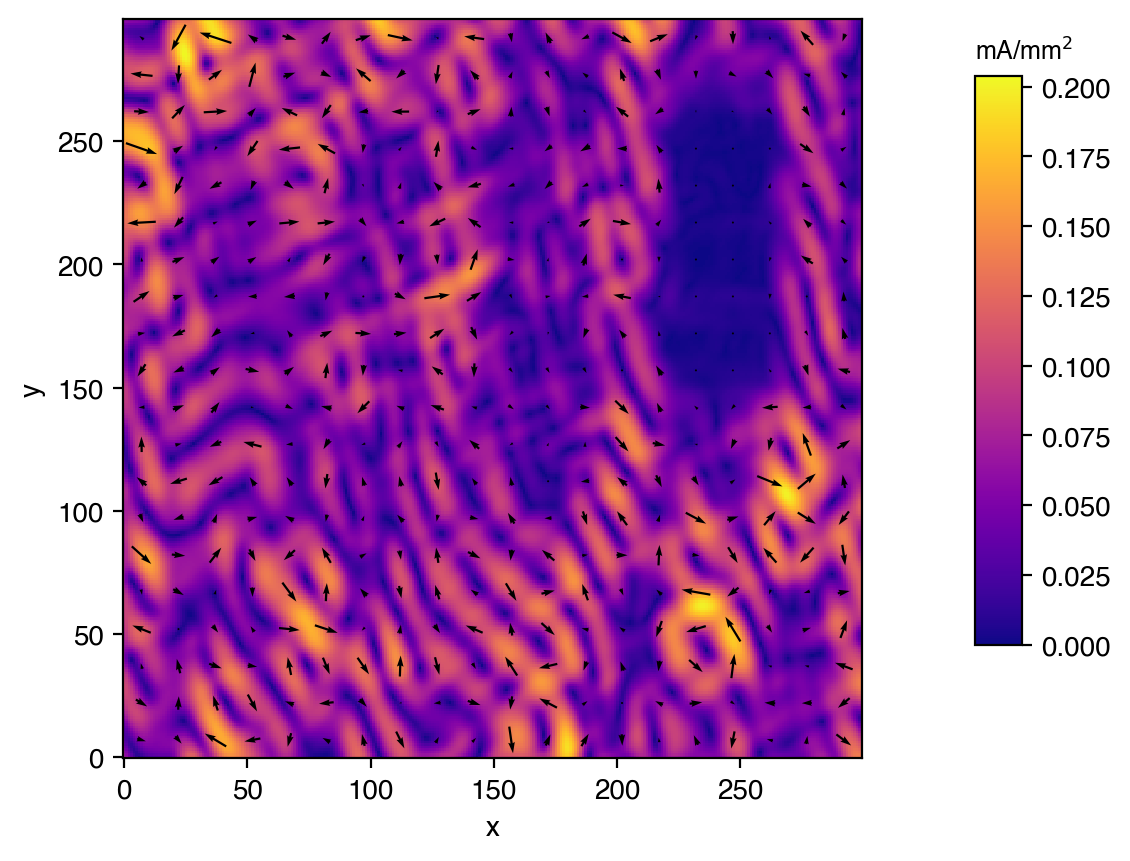

In [28]:
flow_fig

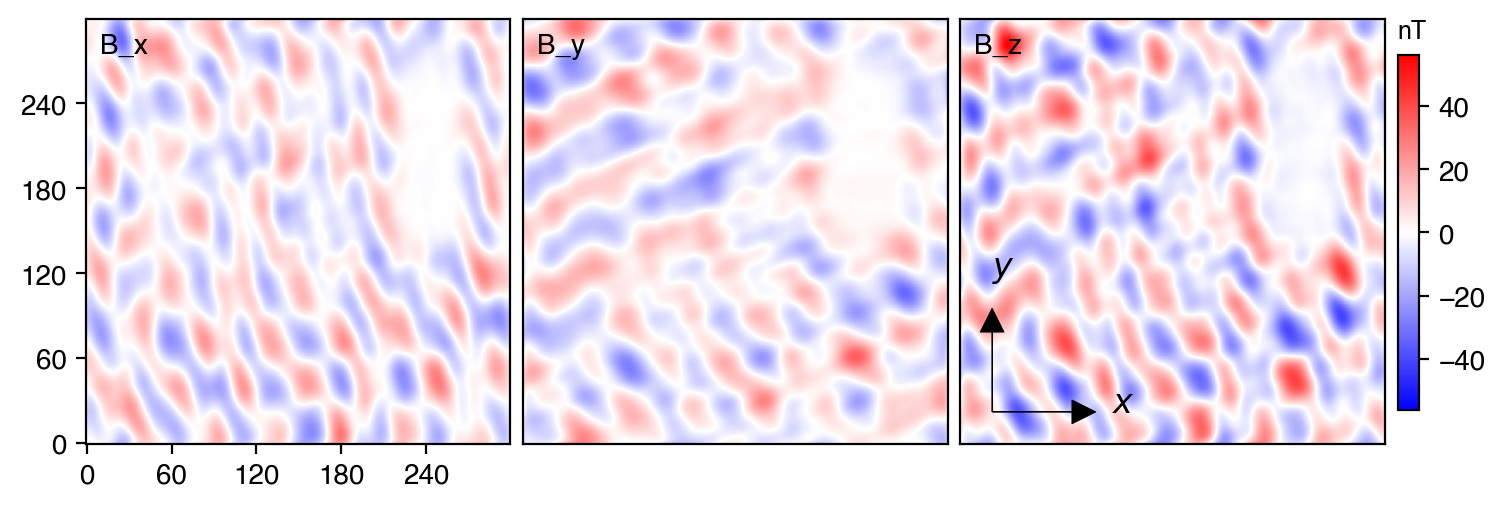

In [29]:
mag_fig

# Jerschow — Learn magnetic field

Goal of this section is to make a neural network $u_{NN}(x, y) = \vec{B}(x, y)$ that learns parameters given a set of measurement $N$ values $\{B^i_{NV}\}_{i = 1, \dots, N}$ obtained for a single component of the magnetic field $B_{NV}$ at different points ${(x_i, y_i)}_{i = 1, \dots, N}$

For this, we take any architecture of the neural network. 

We implement sampling of coordinates on a grid in a rectangle. There are two types of points: those with measurement values and those without. Those with measurement values should have corresponding values of the field. Those without can still be sampled to enforce additional constraints, besides the experimental data constraints. Such constraints, in the case of the magnetic field, are $\nabla\cdot\vec{B} = 0$ and $\nabla \times \vec{B} = 0$. 

## Neural network architecture

We have two neural networks to try. 

1. One learnes a mapping $(x, y, z) \mapsto \vec{B}(x, y, z)$ and receives the constraint $\nabla\cdot\vec{B} = 0$ together with $\nabla\times\vec{B} = 0$ as an additional loss term. 

2. The other learns a mapping $(x, y) \mapsto \vec{B}(x, y)$ and outputs a 2D vector field already free from divergence by construction.

Beyond that, there are also other approaches:

3. Use a neural network to learn a mapping $(x, y) \mapsto \vec{J}(x, y)$, again with the constraint $\nabla\cdot\vec{J} = 0$ either enforced by construction or as an additional loss term. Then, integrate the current to obtain the magnetic field.

4. We can also do all of the above directly in the Fourier space.

Below let's implement the first approach.

## Data to learn

What data should we try to learn? Let's start with a squiggly wire from Jerschow's dataset.

In [ ]:

class JerschowExperimentLearnB(JerschowExperiment):
    def __init__(self, config):
        super().__init__(config)
        # define extra loss terms to track
        self.losses = {
            "total": [],
            "data": [],
            "curl": [],
            "div": [],
        }
        self.is_trained = False
        
    def load_data(self):
        # Define extra data points for curl and div calculations used in this experiment
        super().load_data()
        
    def get_data_sample(self, n):
        """Returns a tensor of shape (n, l) with n batched samples from an
        l-d space where data is available."""
        list_of_indices = torch.randint(low=0, high=len(self.data_pts), size=(n,))
        return self.data_pts[list_of_indices], self.data_vals[list_of_indices]
        
    def get_curl_sample(self, n):
        """Returns a tensor of shape (n, l) with n batched samples from an 
        l-d space where to calculate curl."""
        n = int(n ** (1/3))
        pts = NDGridPoints.get_grid_pts(n, n, n, origin=(0, 0, 0), diagonal=(1, 1, 2))
        vals = torch.zeros(pts.shape[0], 3)  # curl is to be zero
        return pts, vals

    def get_div_sample(self, n):
        n = int(n ** (1/3))
        pts = NDGridPoints.get_grid_pts(n, n, n, origin=(0, 0, 0), diagonal=(1, 1, 2))
        vals = torch.zeros(pts.shape[0])  # div is to be zero, it's values are a list of points
        return pts, vals
    
    def train(self, n_iters=1000, **kwargs):
        data_batch_size = self.config.data_batch_size
        batch_size = self.config.batch_size
        eps_data = self.config.eps_data
        eps_curl = self.config.eps_curl
        eps_div = self.config.eps_div
    
        if "lr" in kwargs:
            self.optimizer.lr = kwargs["lr"]
        
        try:
            for i in tqdm.trange(n_iters):
                # Implement the training loop specific to Jerschow Experiment
                # sample data points 
                train_pts, data_targets = self.get_data_sample(n=data_batch_size)
                curl_pts, curl_targets = self.get_curl_sample(n=batch_size)
                div_pts, div_targets = self.get_div_sample(n=batch_size)
                
                data_est = self.model(train_pts)
                data_loss = self.loss_fn(data_est, data_targets)
                
                curl_vals = self.get_curl_vals(curl_pts)
                curl_loss = self.loss_fn(curl_vals, curl_targets)
                
                div_vals = self.get_div_vals(div_pts)
                div_loss = self.loss_fn(div_vals, div_targets)
                
                loss = eps_data * data_loss + eps_curl * curl_loss + eps_div * div_loss
                
                self.losses["curl"].append(curl_loss.item())
                self.losses["div"].append(div_loss.item())
                self.losses["data"].append(data_loss.item())
                self.losses["total"].append(loss.item())
                
                loss.backward()
                self.optimizer.step()
                # zero the gradients
                self.optimizer.zero_grad()
        except KeyboardInterrupt:
            print("Training interrupted.")
        
        self.is_trained = True
                
        return self

## GaussianFourierFeatures model

In [18]:
# 1. Instantiate Configuration
config = JerschowExperimentConfig('Sine_wire.txt',
                                  model_params=dict(n_inputs=3, n_outputs=3, 
                                                    ff_stds=[(0.1, 10), (20, 5), (5, 5)]),
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  nz_points=100,
                                  eps_curl=1,
                                  eps_data=1,
                                  eps_div=1,)

Define a proper version of sampling pts for curl and div losses. Before it used to be a grid, that is, specific points. Now it should be a random sample of points.

In [31]:
class JerschowExperimentLearnBRandomPts(JerschowExperimentLearnB):

    def get_curl_sample(self, n):
        dx = self.config.dx
        dy = self.config.dy
        height = self.config.height
        nx_points = self.config.nx_points
        ny_points = self.config.ny_points
        
        volume_pts = NDGridPoints.get_random_pts(n,
            origin=(0, 0, 0), 
            diagonal=(dx * nx_points, dy * ny_points, 2 * height))
        
        return volume_pts, torch.zeros(n, 3)
    
    def get_div_sample(self, n):
        dx = self.config.dx
        dy = self.config.dy
        height = self.config.height
        nx_points = self.config.nx_points
        ny_points = self.config.ny_points
        
        volume_pts = NDGridPoints.get_random_pts(n,
            origin=(0, 0, 0), 
            diagonal=(dx * nx_points, dy * ny_points, 2 * height))
        
        return volume_pts, torch.zeros(n)

Let's manually check at random points whether the curl and div are zero.

In [83]:
def check_curl_div_at_rnd_pts(experiment):
    dx = experiment.config.dx
    dy = experiment.config.dy
    height = experiment.config.height
    nx_points = experiment.config.nx_points
    ny_points = experiment.config.ny_points
    
    rnd_pts = NDGridPoints.get_random_pts(1000, origin=(0, 0, 0), 
        diagonal=(dx * nx_points, dy * ny_points, 2 * height))
    
    curl_vals = experiment.get_curl_vals(rnd_pts)
    div_vals = experiment.get_div_vals(rnd_pts)
    
    print(
        'Curl loss: ',
        torch.nn.functional.mse_loss(
        curl_vals, torch.zeros_like(curl_vals)).item(), 
        ' vs ', 
        experiment.losses["curl"][-1])
    print(
        'Div loss: ',
        torch.nn.functional.mse_loss(div_vals, torch.zeros_like(div_vals)).item(),
        ' vs ',
        experiment.losses["div"][-1])

In [44]:
config = JerschowExperimentConfig('Sine_wire.txt',
                                  model_params=dict(n_inputs=3, n_outputs=3, 
                                                    ff_stds=[(0.1, 10), (2, 5), (5, 5)]),
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  lr=1e-2,
                                  nz_points=100,
                                  eps_curl=1,
                                  eps_data=1,
                                  eps_div=1,)

experiment = JerschowExperimentLearnBRandomPts(config)
experiment.load_data()

In [45]:
experiment.train(n_iters=100000)

100%|██████████| 100000/100000 [35:16<00:00, 47.24it/s] 


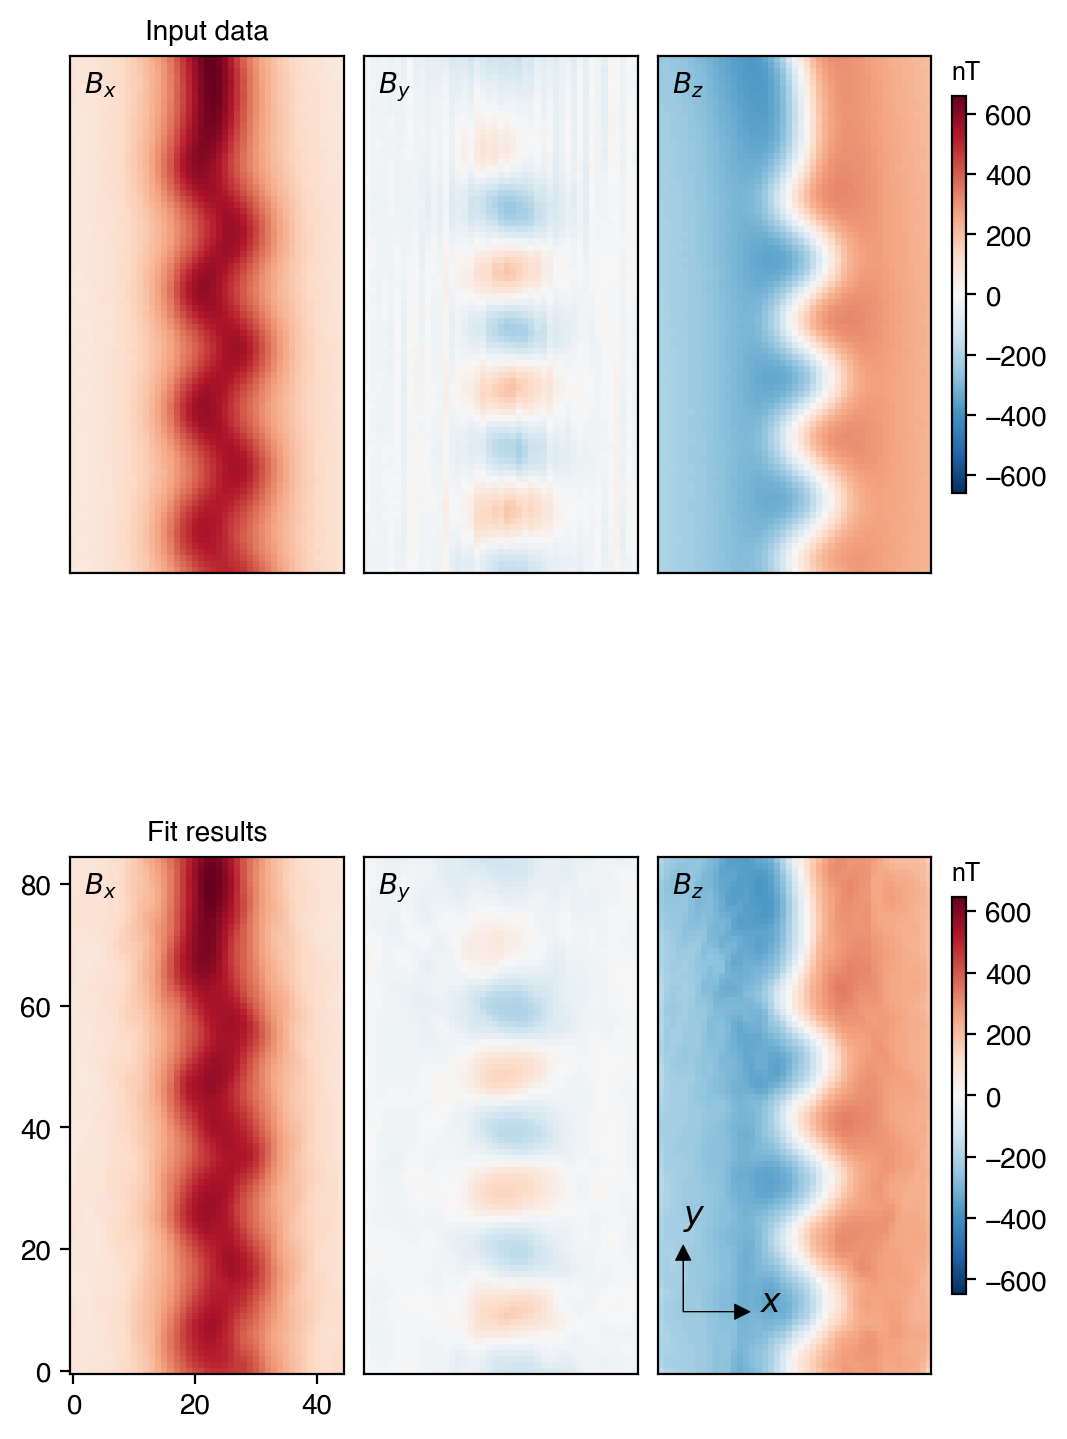

In [47]:
experiment.plot_results()

The results are not good. Is this due to the frequencies chosen? 

<Axes: >

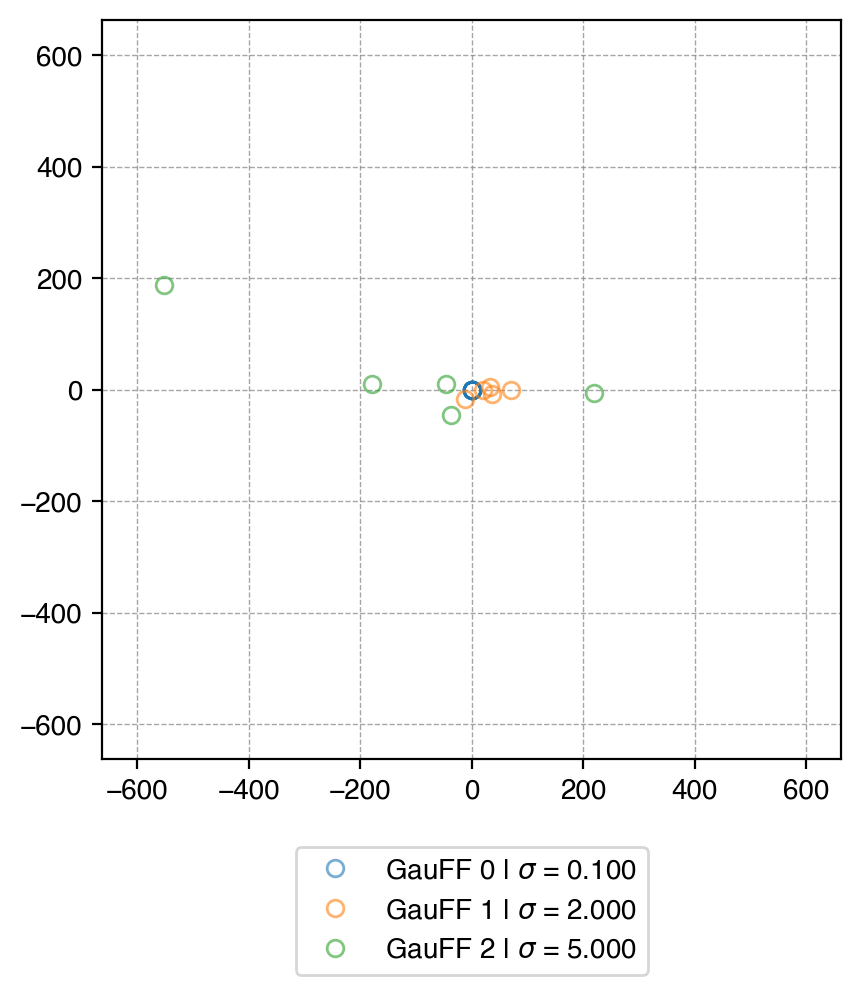

In [48]:
plot_ffs_params(experiment.model)

Let's save the results of the training, since they are not so bad. In fact, we have cleaned some systematic errors and got rid of the stripes. However, we introduced some inhomogeneous patches. Especially so in $B_z$ image. 

In [53]:
save_model_for_experiment(experiment, __datapath__ / 'model_state_dict_GauFF.pt')

To load the trained model, we may create a clean config and run the code below to propagate the parameters from the file:

In [ ]:
# that's a good model here, trained like below:
experiment_test = load_model_for_experiment(experiment, __datapath__ / 'model_state_dict_GauFF.pt')

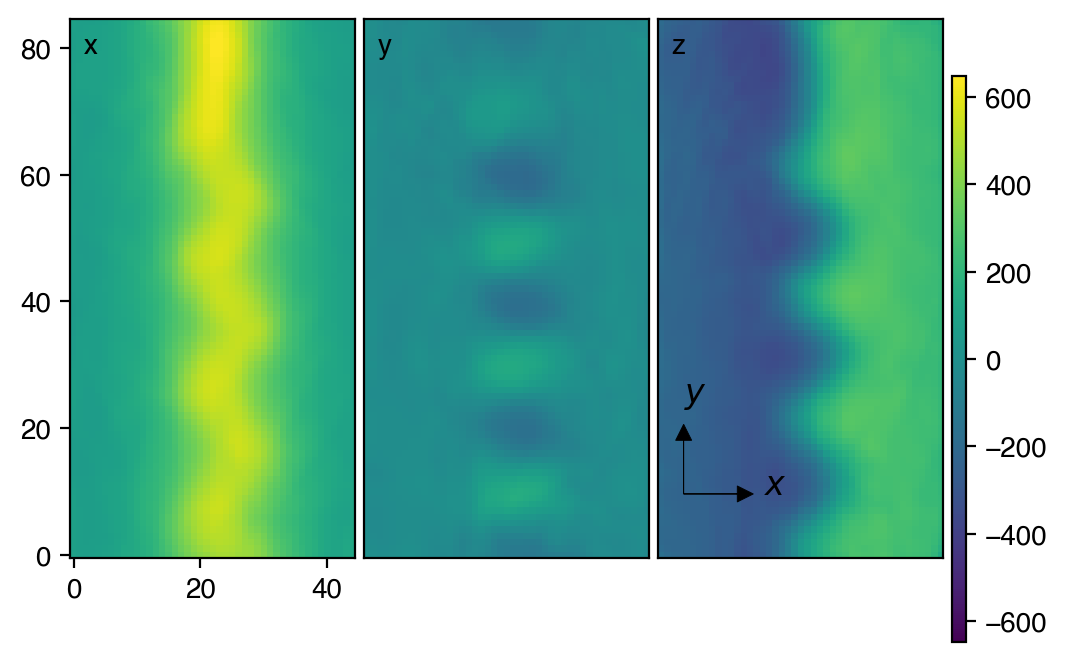

In [55]:
try:
    plot_n_components(experiment_test.config.data.get_as_grid("B_fit"))
except AttributeError:
    experiment_test.config.data.map(experiment_test.model, "B_fit")

plot_n_components(experiment_test.config.data.get_as_grid("B_fit"))

In [56]:
expanded = experiment.config.data.expand_bounds_2d(1)

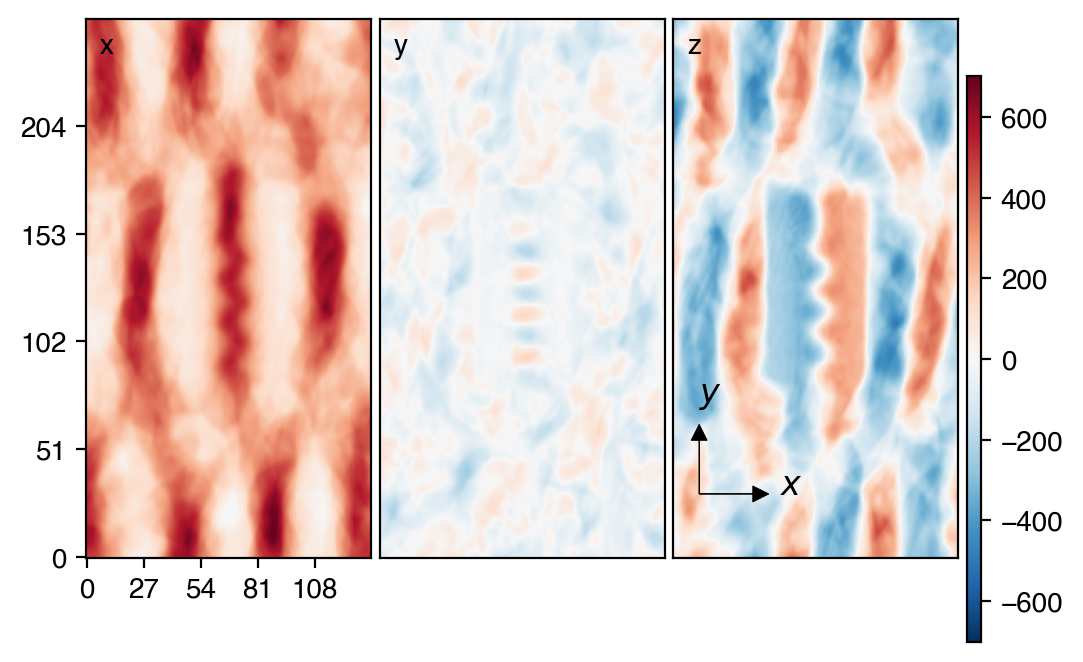

In [59]:
expanded[1].map(experiment.model, "B_fit")
plot_n_components(expanded[1].get_as_grid("B_fit"), cmap="RdBu_r")

Now we want to try the same training but with with different (or at least controller) Fourier features frequencies. Let's first see what frequencies has been randomly generated by the model.

<Axes: >

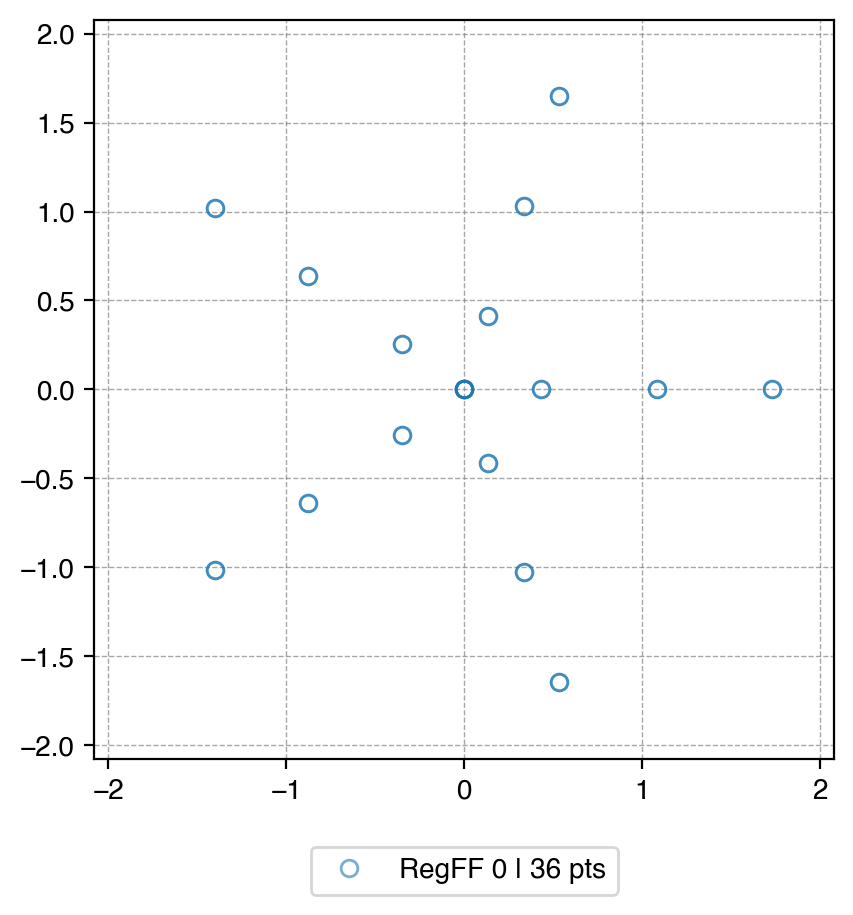

In [62]:
plot_ffs_params(RegularFourierFeaturesTransform(3, r_in=0.5, r_out=2, r_res=3, c_res=(6, 4)))

The model has been initialized with new params.


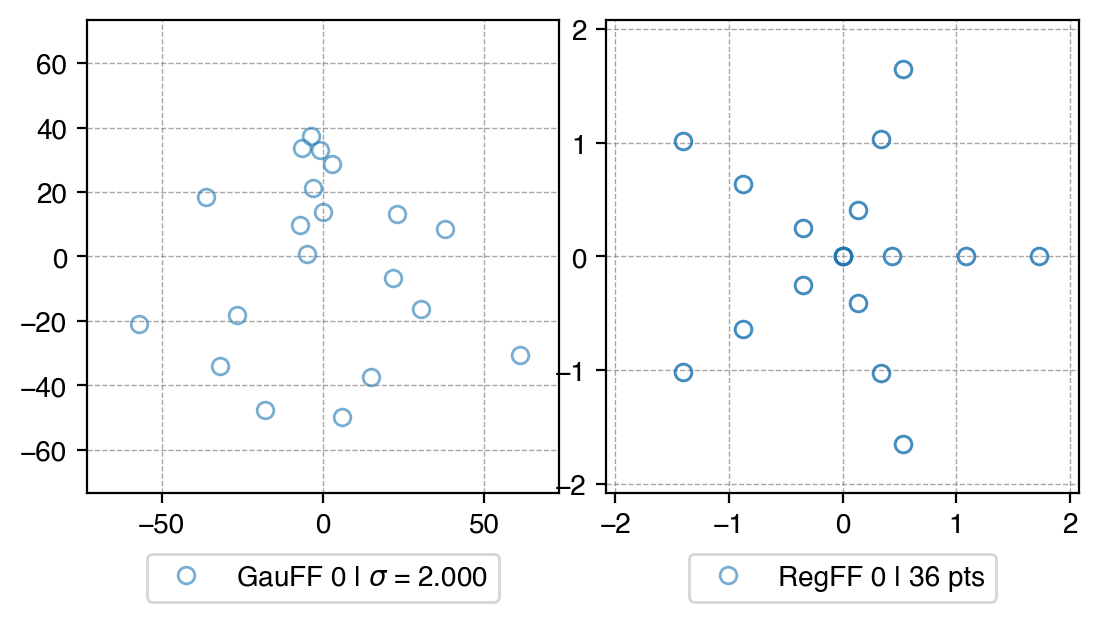

If reinitializing the trained model is not intended, press undo.


Button(description='Undo', style=ButtonStyle())

Output()

In [66]:
experiment.model.set_ffs(RegularFourierFeaturesTransform(3, r_in=0.5, r_out=2, r_res=3, c_res=(6, 4)), verbose=True)

100%|██████████| 100000/100000 [27:48<00:00, 59.92it/s]


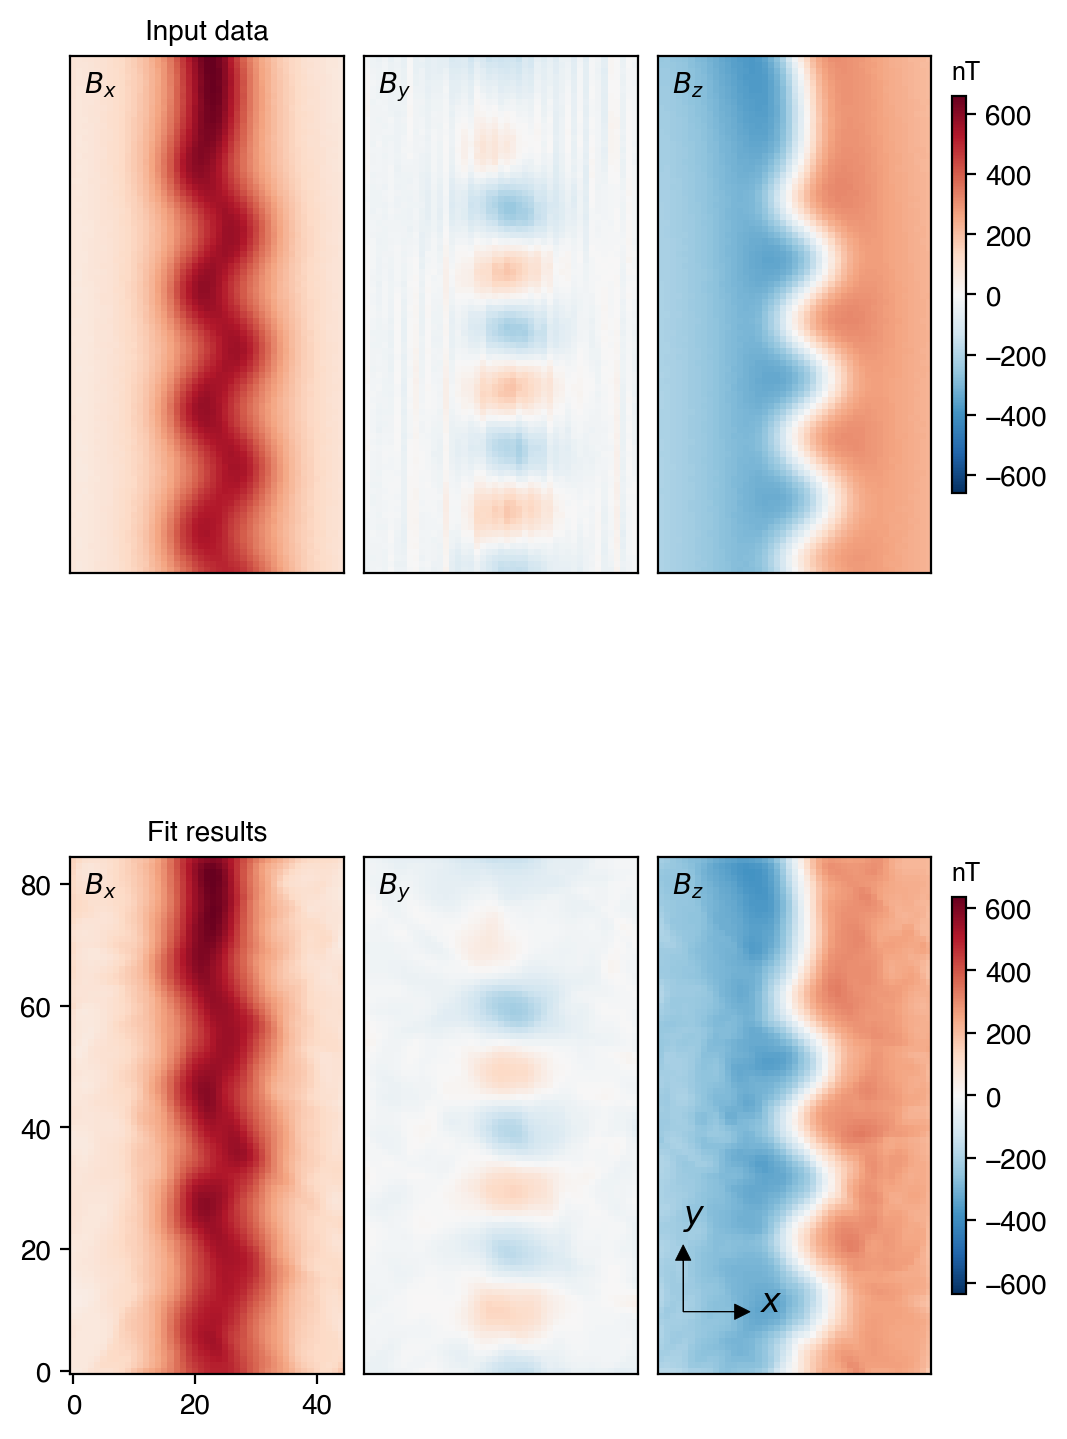

In [60]:
config = JerschowExperimentConfig('Sine_wire.txt',
                                  model_params=dict(n_inputs=3, n_outputs=3, 
                                                    ff_stds=[(0.1, 10), (2, 5), (3, 5)]),
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  lr=1e-2,
                                  nz_points=100,
                                  eps_curl=1,
                                  eps_data=1,
                                  eps_div=1,)

experiment = JerschowExperimentLearnBRandomPts(config)
experiment.load_data()

experiment.train(n_iters=100000)
experiment.plot_results()

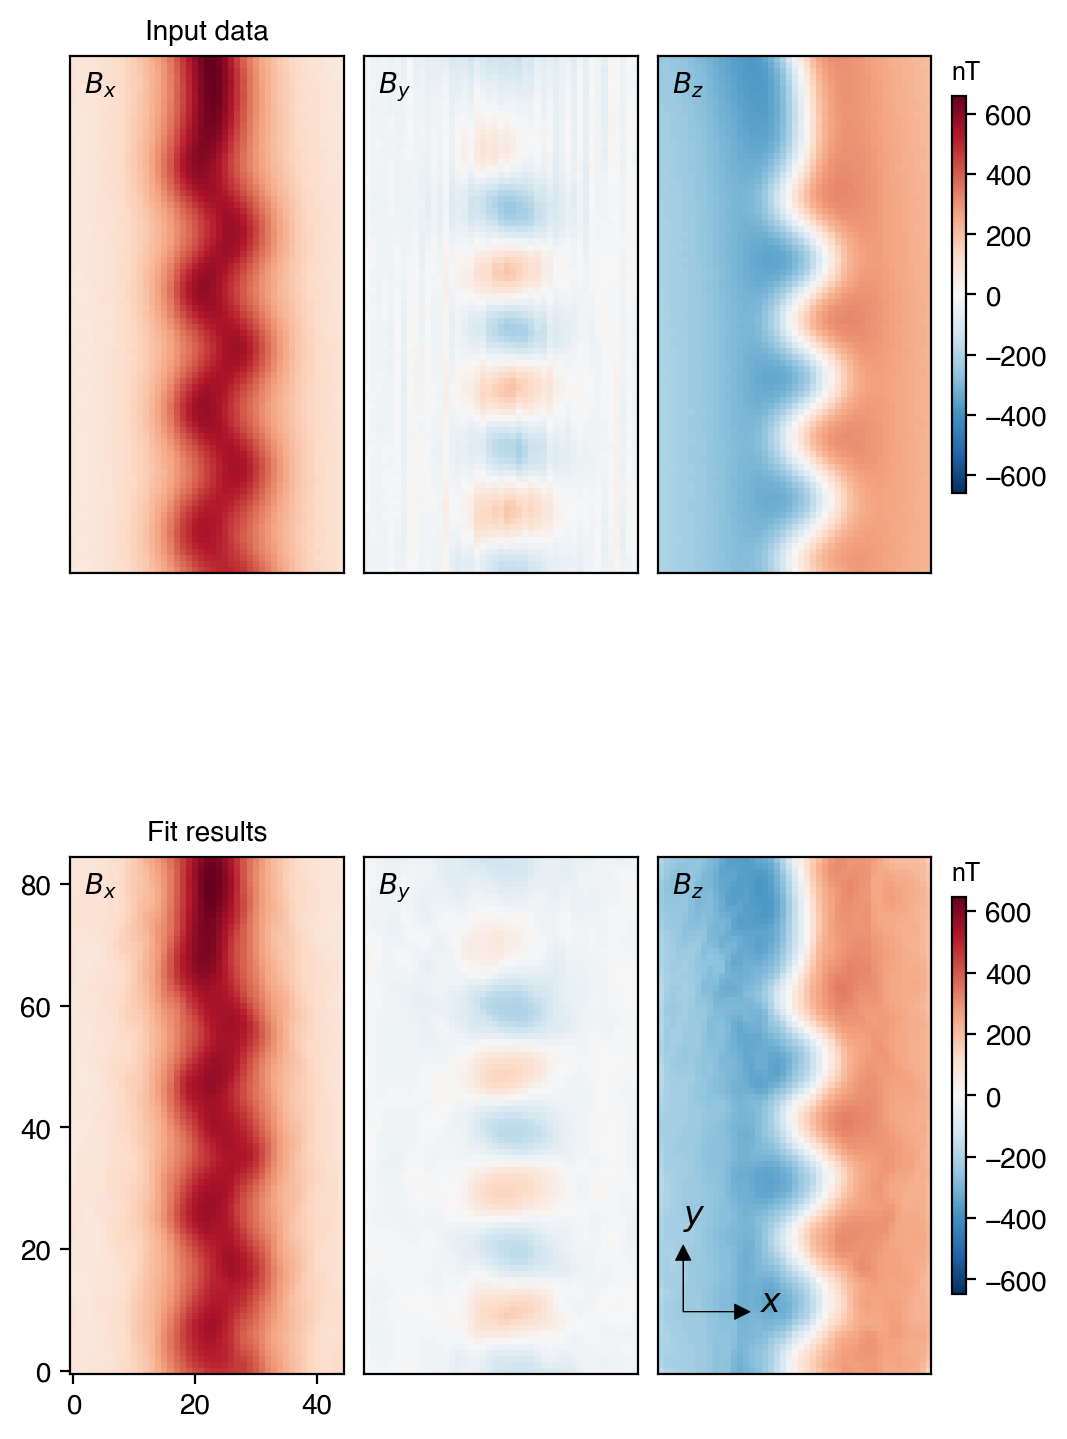

In [62]:
experiment_test.plot_results()

<Axes: >

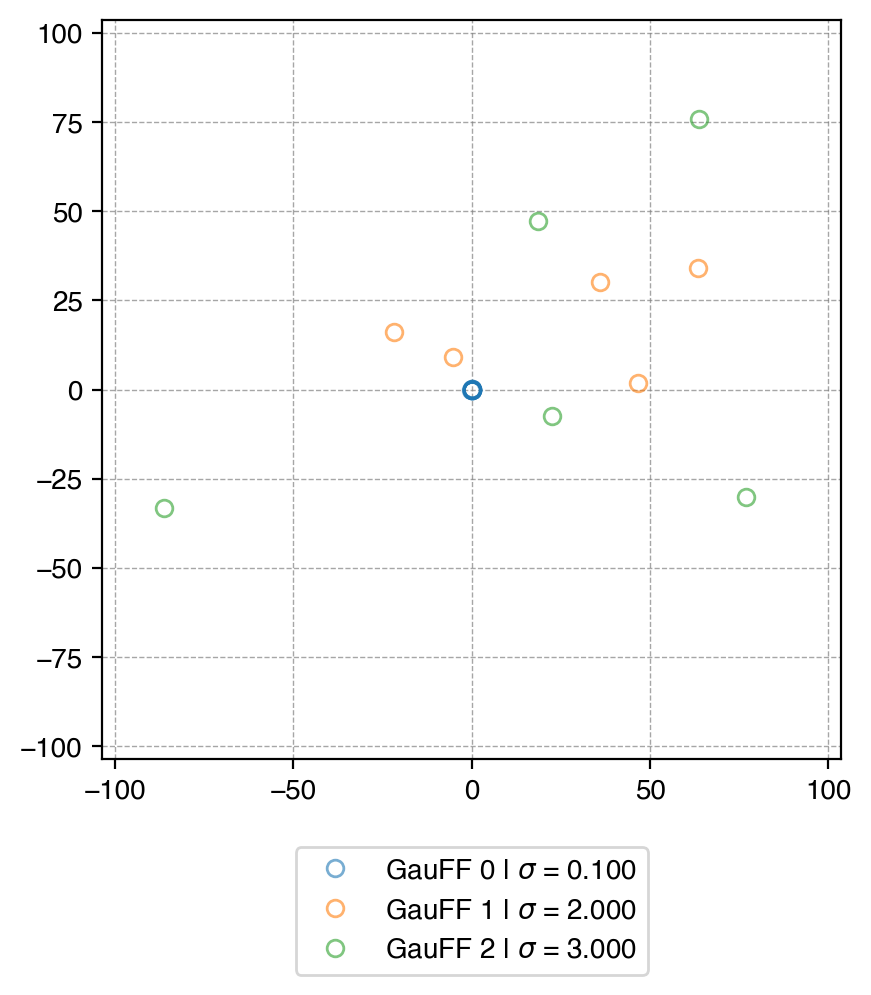

In [61]:
plot_ffs_params(experiment.model)

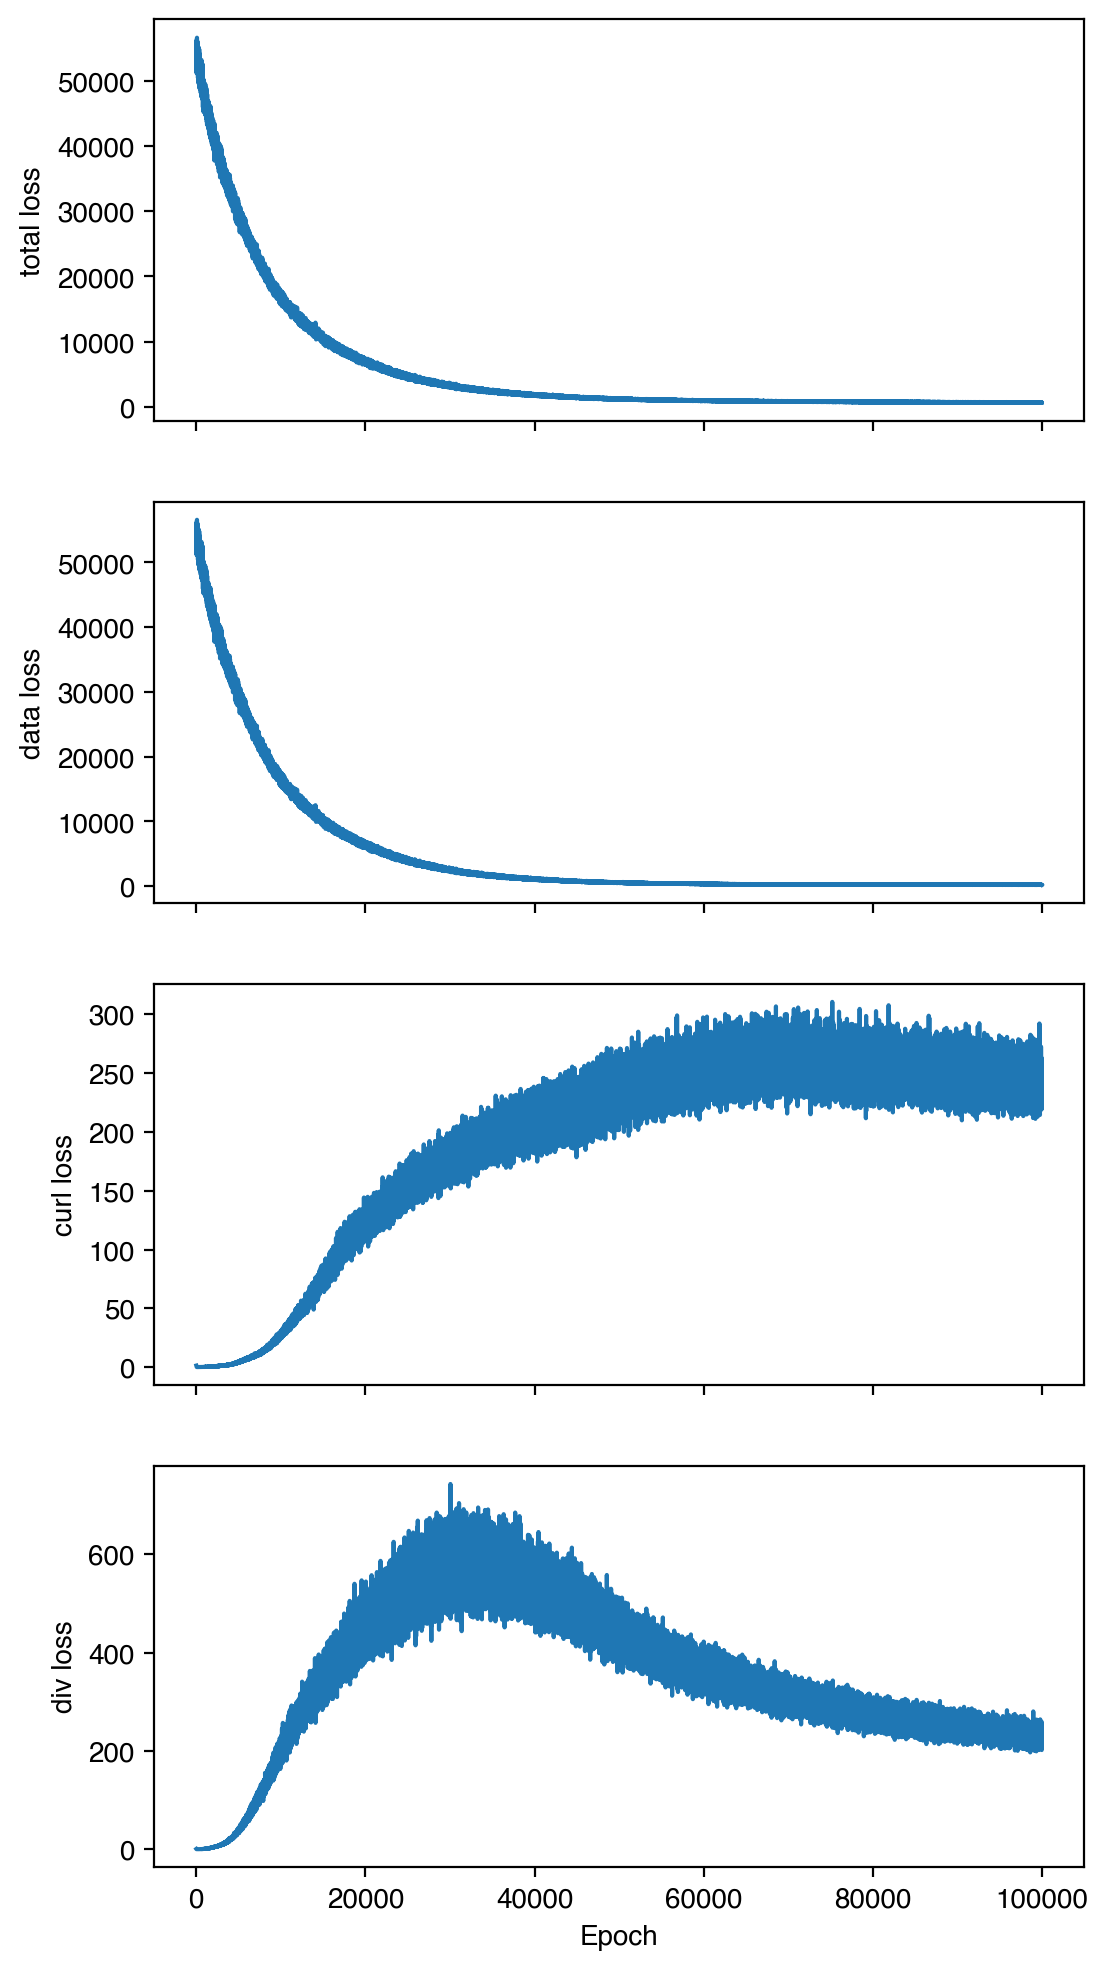

In [63]:
experiment.plot_losses()

In [ ]:
experiment.train(n_iters=100000)
experiment.plot_results()

 13%|█▎        | 13492/100000 [03:50<25:07, 57.37it/s]

## What doesn't work

100%|██████████| 100000/100000 [18:02<00:00, 92.36it/s]


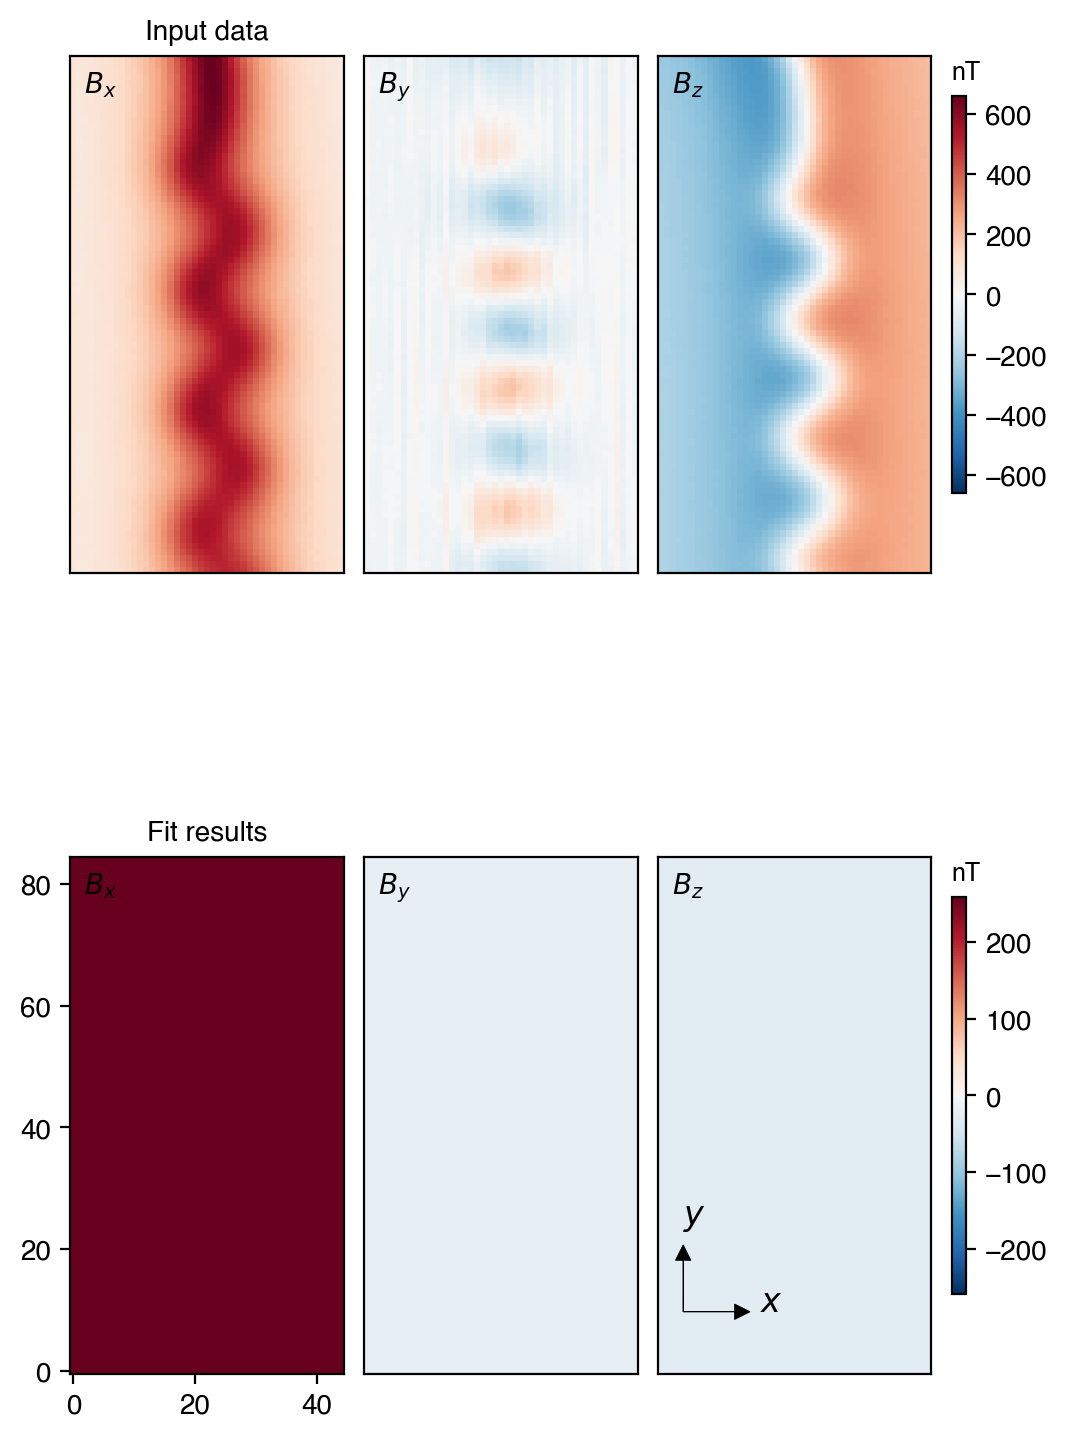

In [25]:
config = JerschowExperimentConfig('Sine_wire.txt',
                                  model_params=dict(n_inputs=3, n_outputs=3, 
                                                    ff_stds=[(4, 20)]),
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  lr=1e-2,
                                  nz_points=100,
                                  eps_curl=1,
                                  eps_data=1,
                                  eps_div=1,)

experiment = JerschowExperimentLearnBRandomPts(config)
experiment.load_data()

experiment.train(n_iters=100000)

experiment.model.is_trained = True
experiment.plot_results()

<Axes: >

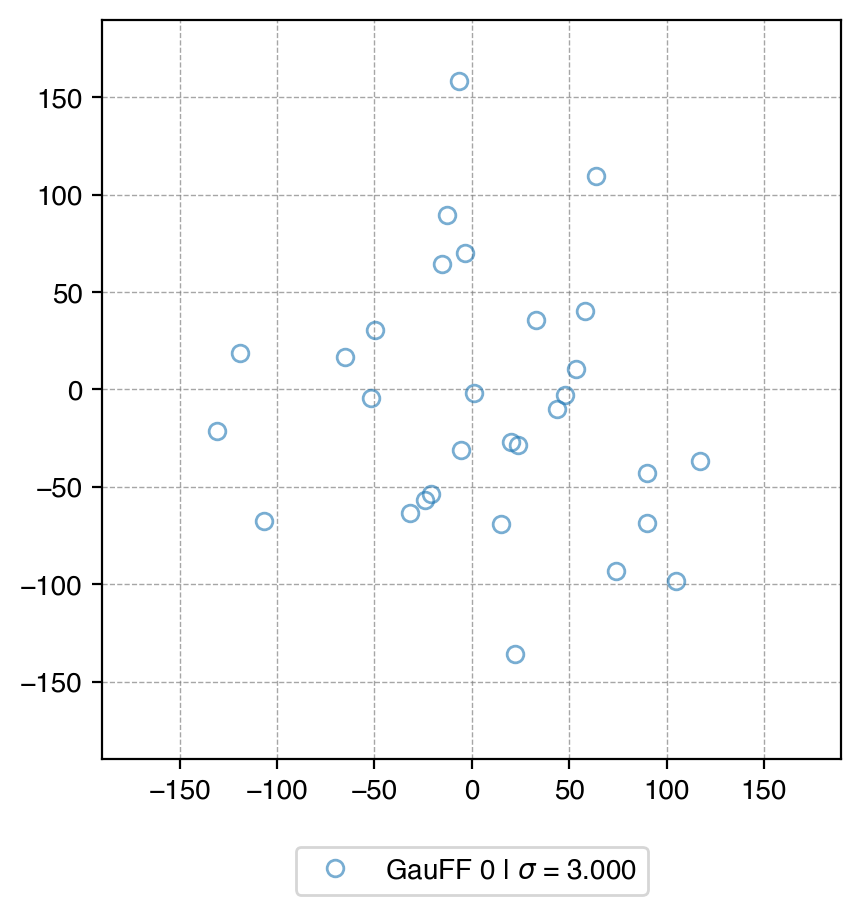

In [30]:
plot_ffs_params(GaussianFourierFeaturesTransform(2, 30, 3))

## Augmenting train loss with extra terms

The idea is to introduce, first, the term that will enfore decaying of the magnetic field outside of the field of view. The rough idea is to extract the values at the boundary of the data and set that as the maximal value of the field outside the field of view. But sort of “less is better”. That should be enforced on `x=0 f.o.v` and `x=1 f.o.v` in relative units (`f.o.v.` is field of view unit, 0 is the beginning of the f.o.v. and 1 is its end). 

I need to create a new class `ExperimentLearnDecayB` and augment the loss function with this new term.

In [ ]:
class JerschowExperimentLearnDecayB(JerschowExperimentLearnBRandomPts):
    def __init__(self, config):
        super().__init__(config)
        # define extra loss terms to track
        self.losses = {
            "total": [],
            "data": [],
            "curl": [],
            "div": [],
        }
        self.is_trained = False
                
    def get_data_sample(self, n):
        """Returns a tensor of shape (n, l) with n batched samples from an
        l-d space where data is available."""
        list_of_indices = torch.randint(low=0, high=len(self.data_pts), size=(n,))
        return self.data_pts[list_of_indices], self.data_vals[list_of_indices]

    def boundary_decay_sample(self, n):
        """Return n random points in the region where the solution should decay."""
        expanded = self.config.data.expand_bounds_2d(factor=1)
        
        expanded[1].map(experiment.model, "B_fit")
        plot_n_components(expanded[1].get_as_grid("B_fit"), cmap="RdBu_r")
    
    def train(self, n_iters=1000, **kwargs):
        data_batch_size = self.config.data_batch_size
        batch_size = self.config.batch_size
        eps_data = self.config.eps_data
        eps_curl = self.config.eps_curl
        eps_div = self.config.eps_div
        eps_decay = self.config.eps_decay
    
        if "lr" in kwargs:
            self.optimizer.lr = kwargs["lr"]
        
        try:
            for i in tqdm.trange(n_iters):
                # Implement the training loop specific to Jerschow Experiment
                # sample data points 
                train_pts, data_targets = self.get_data_sample(n=data_batch_size)
                curl_pts, curl_targets = self.get_curl_sample(n=batch_size)
                div_pts, div_targets = self.get_div_sample(n=batch_size)
                bd_decay_pts, bd_decay_targets = self.boundary_decay_sample(n=batch_size)
                
                data_est = self.model(train_pts)
                data_loss = self.loss_fn(data_est, data_targets)
                
                curl_vals = self.get_curl_vals(curl_pts)
                curl_loss = self.loss_fn(curl_vals, curl_targets)
                
                div_vals = self.get_div_vals(div_pts)
                div_loss = self.loss_fn(div_vals, div_targets)
                
                bd_decay_vals = self.model(bd_decay_pts)
                bd_decay_loss = self.loss_fn(bd_decay_vals, bd_decay_targets)
                
                loss = eps_data * data_loss + eps_curl * curl_loss + eps_div * div_loss + eps_decay * bd_decay_loss
                
                self.losses["curl"].append(curl_loss.item())
                self.losses["div"].append(div_loss.item())
                self.losses["data"].append(data_loss.item())
                self.losses["bd_decay"].append(bd_decay_loss.item())
                self.losses["total"].append(loss.item())
                
                loss.backward()
                self.optimizer.step()
                # zero the gradients
                self.optimizer.zero_grad()
        except KeyboardInterrupt:
            print("Training interrupted.")
        
        self.is_trained = True
        return self

# Jerschow — Learn magnetic potential

Goal of this section is to make a neural network $u_{NN}(x, y, z) = {\Phi}(x, y, z)$ that learns parameters given a set of measurement $N$ values $\{B^i_{NV}\}_{i = 1, \dots, N}$ obtained for a single component of the magnetic field $B_{NV}$ at different points ${(x_i, y_i)}_{i = 1, \dots, N}$ such that $\vec{B} = \nabla \Phi$.

In [ ]:
class JerschowExperimentLearnPot(JerschowExperiment):
    def __init__(self, config):
        super().__init__(config)
        # define extra loss terms to track                                                         
        self.losses = {
            "total": [],
            "data": [],
            "curl": [],
            "div": [],
        }
        
    def load_data(self):
        # Define extra data points for curl and div calculations used in this experiment
        super().load_data()
        
    def get_data_sample(self, n):
        """Returns a tensor of shape (n, l) with n batched samples from an
        l-d space where data is available."""
        list_of_indices = torch.randint(low=0, high=len(self.data_pts), size=(n,))
        return self.data_pts[list_of_indices], self.data_vals[list_of_indices]
    
    def get_B(self, pts: torch.Tensor):
        """The magnetic field B is obtained by applying the gradient to the output of the model."""
        pts.requires_grad = True
        # compute grad of y wrto inputs (pts) at pts
        return batched_grad(self.model)(pts)
    
    
    def train(self, n_iters=1000, **kwargs):
        data_batch_size = self.config.data_batch_size
    
        if "lr" in kwargs:
            self.optimizer.lr = kwargs["lr"]
        
        try:
            self.model.train()
            for i in tqdm.trange(n_iters):
                # Implement the training loop specific to Jerschow Experiment
                # sample data points 
                train_pts, data_targets = self.get_data_sample(n=data_batch_size)
                
                data_est = self.get_B(train_pts)
                data_loss = self.loss_fn(data_est, data_targets)
                
                loss = data_loss
                self.losses["data"].append(data_loss.item())
                
                loss.backward()
                self.optimizer.step()
                # zero the gradients
                self.optimizer.zero_grad()
        except KeyboardInterrupt:
            print("Training interrupted. Safely closing the experiment.")
            self.model.is_trained = True
            self.model.eval()
            
        return self

In [90]:
pot_config = JerschowExperimentConfig('Sine_wire.txt',
                                  data_batch_size=1000,
                                  batch_size=1000,
                                  lr=1e-3,)

pot_config.model = torch.nn.Sequential(
    torch.nn.Linear(3, 10),
    torch.nn.Sigmoid(),
    torch.nn.Linear(10, 10),
    torch.nn.Sigmoid(),
    torch.nn.Linear(10, 1),
)

In [ ]:
pot_experiment = JerschowExperimentLearnPot(pot_config)
pot_experiment.load_data()
pot_experiment.train(n_iters=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000, 3])) that is different to the input size (torch.Size([1000, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|▏         | 1439/100000 [00:06<07:52, 208.70it/s]


KeyboardInterrupt: 

: 

# Wire — Reconstruct path with the neural network

In [ ]:
def test_path(s):
    r = torch.cat([s, torch.sin(30*s)], dim=1)
    r = rotate_vector_field_2d(r, 45 / 360 * 2 * torch.pi)
    return r

net = WireNet()


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name | Type     | Params
----------------------------------
0 | net  | WirePath | 992   
----------------------------------
992       Trainable params
0         Non-trainable params
992       Total params
0.004     Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
net.fit_to_path(test_path, n_points=200, max_epochs=40)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type     | Params
----------------------------------
0 | net  | WirePath | 992   
----------------------------------
992       Trainable params
0         Non-trainable params
992       Total params
0.004     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


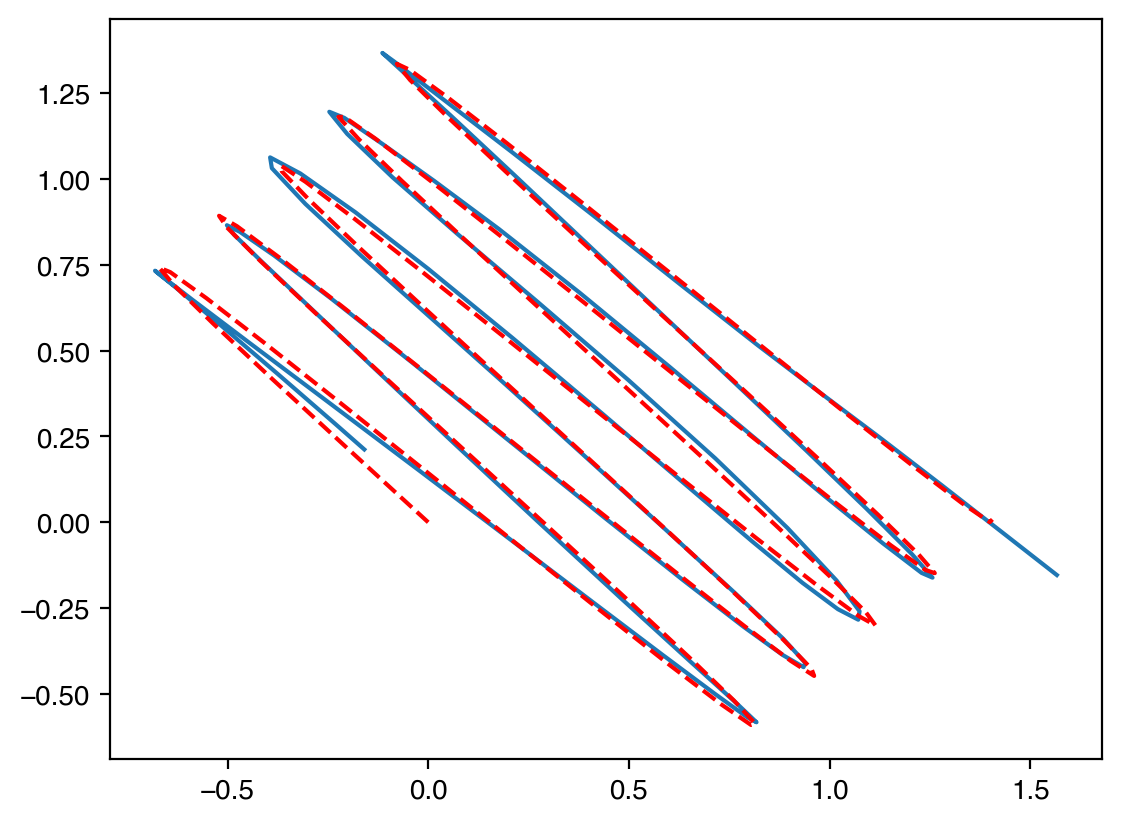

In [ ]:
net.plot_wire()

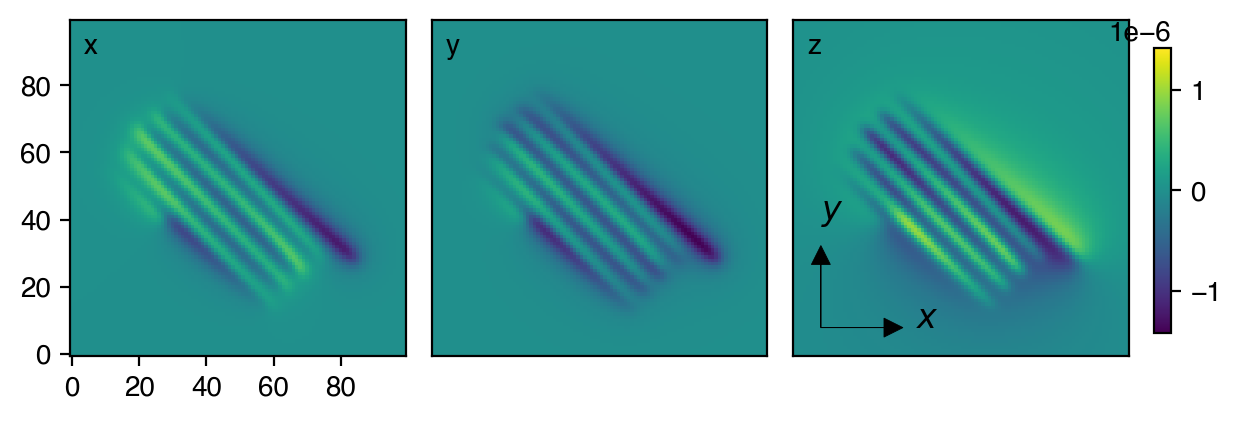

In [ ]:
net.net.I = 1
plane_pos = GridSampler.sample_grid(100, 100, origin=[-1, -1], diagonal=[2, 2], z=0.1)
plane_pos = plane_pos.numpy()

B = net.get_B(pos=plane_pos)
B = GridSampler.pts_to_grid(B, 100, 100)

plot_n_components(B)

# Questions



Where to put `ExperimentConfig` class and `JerschowExperiment`? 

Where to put plotting function to visualize loaded data, which is load function specific?